In [ ]:
# =============================================================
# PURPOSE OF THIS 5-EPOCH EXPERIMENT
# =============================================================
# These models were trained for exploratory purposes to gain a deeper understanding of the Faster R-CNN pipeline.
# They serve as an intermediate step toward the final baseline model, which was later trained for 20 epochs.
# Although not used in the final evaluation, they were essential for:
# - Verifying dataset format and loading logic (Pascal VOC)
# - Debugging the training loop and loss computation
# - Observing convergence behavior with minimal training

# **Install PyTorch**





In [ ]:
!pip install -U torch torchvision tqdm lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# **Mounting Goodle Drive & Set Path**

In [2]:
# === Mount google drive ============
from google.colab import drive
drive.mount('/content/drive')

# === Set path for PASCAL VOC dataset ===
import os
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc"

Mounted at /content/drive


# **BASELINE FASTER R-CNN TRAINING SCRIPT**

In [3]:
# =============================================================
# TRAINING FASTER R-CNN ON RAW SONAR IMAGES (5 EPOCHS)
# =============================================================
# This script trains Faster R-CNN on the raw (non-denoised) sonar images.
# It uses the AdamW optimizer instead of SGD because:
# - It converges faster on small datasets like sonar
# - It's more stable when training for only a few epochs
# - It decouples weight decay from the optimization step, which promotes better generalization
# We apply basic transformation (ToTensor). Additional preprocessing (e.g., median blur, CLAHE+Augmentation) are used after training the baseline model on raw data
# -------------------------------------------------------------
# STEP 0: Import necessary libraries
# -------------------------------------------------------------
import os
import sys
import torch
import torchvision
import torchvision.transforms as T
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Add path to my custom dataset loader (voc_dataset.py)
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# STEP 1: Set device
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------------------------------------
# STEP 2: Define the collate function
# -------------------------------------------------------------
def collate_fn(batch):
    return tuple(zip(*batch))  # Groups images and targets for object detection

# -------------------------------------------------------------
# STEP 3: Load raw sonar dataset (train & val splits)
# -------------------------------------------------------------
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc"
transform = T.ToTensor()

train_dataset = VOCDataset(root=DATASET_DIR, image_set="train", transforms=transform)
val_dataset   = VOCDataset(root=DATASET_DIR, image_set="val", transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# -------------------------------------------------------------
# STEP 4: Load pretrained Faster R-CNN and customize head
# -------------------------------------------------------------
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace classifier head to match sonar class count
num_classes = 3  # 0 = background, 1 = object, 2 = shadow
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

# -------------------------------------------------------------
# STEP 5: Use AdamW optimizer instead of SGD
# -------------------------------------------------------------
# AdamW is chosen for better performance on small datasets and short training schedules.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)

# -------------------------------------------------------------
# STEP 6: Training loop (5 epochs)
# -------------------------------------------------------------
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")

# -------------------------------------------------------------
# STEP 7: Save the trained model to checkpoints folder
# -------------------------------------------------------------
checkpoint_dir = "/content/drive/MyDrive/sonar-object-detection/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

save_path = os.path.join(checkpoint_dir, "baseline_fasterrcnn_5epoch.pth")
torch.save(model.state_dict(), save_path)
print(f"\nModel saved to: {save_path}")

Using device: cuda
Training samples: 1366
Validation samples: 242
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 194MB/s]
Epoch 1/5: 100%|██████████| 342/342 [12:13<00:00,  2.15s/it]


Epoch 1/5 — Avg Loss: 1.1729


Epoch 2/5: 100%|██████████| 342/342 [00:42<00:00,  8.07it/s]


Epoch 2/5 — Avg Loss: 1.0869


Epoch 3/5: 100%|██████████| 342/342 [00:42<00:00,  8.06it/s]


Epoch 3/5 — Avg Loss: 1.0482


Epoch 4/5: 100%|██████████| 342/342 [00:42<00:00,  8.04it/s]


Epoch 4/5 — Avg Loss: 1.0250


Epoch 5/5: 100%|██████████| 342/342 [00:42<00:00,  8.05it/s]


Epoch 5/5 — Avg Loss: 1.0084

Model saved to: /content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_fasterrcnn_5epoch.pth


## **inference_and_visualization.py**

In [4]:
# =============================================================
# BATCH INFERENCE: APPLY FASTER R-CNN TO ALL IMAGES IN FOLDER
# =============================================================
# This version is batch-optimized and fixes OpenCV image type issues.
# It processes all sonar images in a dataset, saves annotated images, and logs predictions to CSV.

import os
import cv2
import sys
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------------------------------------
# STEP 1: CONFIGURATION
# -------------------------------------------------------------
# Define key paths for images, model checkpoint, output folder, and prediction CSV

PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR      = PROJECT_ROOT / "data" / "line2voc" / "JPEGImages"
MODEL_PATH   = PROJECT_ROOT / "checkpoints" / "baseline_fasterrcnn_5epoch.pth"
OUTPUT_DIR   = PROJECT_ROOT / "outputs" / "baseline_5epoch_vis"
PRED_CSV     = PROJECT_ROOT / "outputs" / "preds_baseline_5epoch.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------
# STEP 2: INFERENCE DATASET: it handles PIL and NumPy versions
# -------------------------------------------------------------
# Custom Dataset for loading images in both formats:
# - PIL for model inference
# - NumPy for OpenCV visualization

class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = list(Path(image_dir).glob("*.jpg"))
        self.transform = transform or ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_pil = Image.open(img_path).convert("RGB")

        img_tensor = self.transform(img_pil)          # For model input
        img_np = np.array(img_pil).astype(np.uint8)   # For OpenCV drawing

        return img_tensor, img_path.name, img_np

# -------------------------------------------------------------
# STEP 3: LOAD MODEL
# -------------------------------------------------------------
# Load pretrained Faster R-CNN, replace classifier head with 3-class predictor (background, object, shadow)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()  # Switch to evaluation mode to disable dropout and batchnorm updates

# -------------------------------------------------------------
# STEP 4: DATA LOADER & CLASS MAPPINGS
# -------------------------------------------------------------
# Batch loader for inference (no shuffling), with label-to-class-name mappings and colors for visualization

dataset = InferenceDataset(IMG_DIR)
loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=lambda x: list(zip(*x)))

CLASS_NAMES = {1: "object", 2: "shadow"}
CLASS_COLORS = {
    1: (0, 255, 0),   # Green for object
    2: (0, 0, 255)    # Red for shadow
}

all_preds = []  # To store results for CSV

# -------------------------------------------------------------
# STEP 5: BATCH INFERENCE
# -------------------------------------------------------------
# Run inference in batches, draw bounding boxes on each image, and store results for CSV logging

print("Running batch inference...")

for batch_imgs, batch_filenames, batch_np_imgs in tqdm(loader, desc="Running Inference"):
    imgs_tensor = [img.to(device) for img in batch_imgs]

    with torch.no_grad():  # Disable gradients to reduce memory and speed up inference
        outputs = model(imgs_tensor)

    for output, fname, img_np in zip(outputs, batch_filenames, batch_np_imgs):
        img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # Convert for OpenCV drawing

        boxes  = output["boxes"].cpu()
        scores = output["scores"].cpu()
        labels = output["labels"].cpu()

        for box, score, label in zip(boxes, scores, labels):
            score = score.item()
            if score < 0.5:
                continue  # Filter out low-confidence predictions

            x1, y1, x2, y2 = map(int, box.tolist())
            class_id = label.item()
            class_name = CLASS_NAMES.get(class_id, "unknown")
            color = CLASS_COLORS.get(class_id, (255, 255, 255))  # Default to white if unknown

            all_preds.append({
                "filename": fname,
                "class_id": class_id,
                "class_name": class_name,
                "score": round(score, 4),
                "xmin": x1,
                "ymin": y1,
                "xmax": x2,
                "ymax": y2,
            })

            cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv2, f"{class_name} ({score:.2f})", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        out_path = OUTPUT_DIR / fname
        cv2.imwrite(str(out_path), img_cv2)  # Save annotated image to disk

# -------------------------------------------------------------
# STEP 6: SAVE TO CSV
# -------------------------------------------------------------
# Save all detection metadata (filename, box, score, label) to CSV for later analysis

df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print(f"Inference complete. Processed {len(dataset)} images.")
print(f"Visuals saved to: {OUTPUT_DIR}")
print(f"Predictions saved to: {PRED_CSV}")

Running batch inference...


Running Inference: 100%|██████████| 447/447 [09:31<00:00,  1.28s/it]


Inference complete. Processed 1788 images.
Visuals saved to: /content/drive/MyDrive/sonar-object-detection/outputs/baseline_5epoch_vis
Predictions saved to: /content/drive/MyDrive/sonar-object-detection/outputs/preds_baseline_5epoch.csv


# **Visualizing Predictions**

Image 1: 26 predictions above threshold


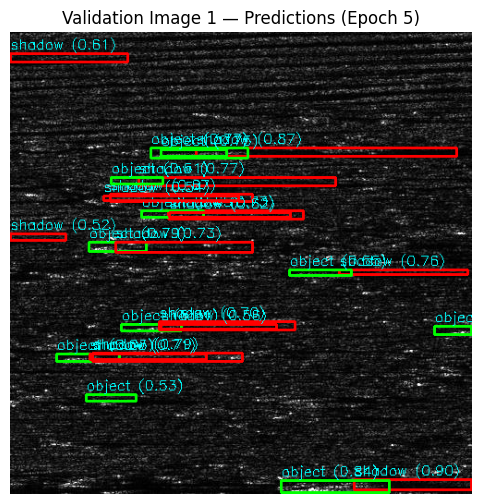

Image 2: 9 predictions above threshold


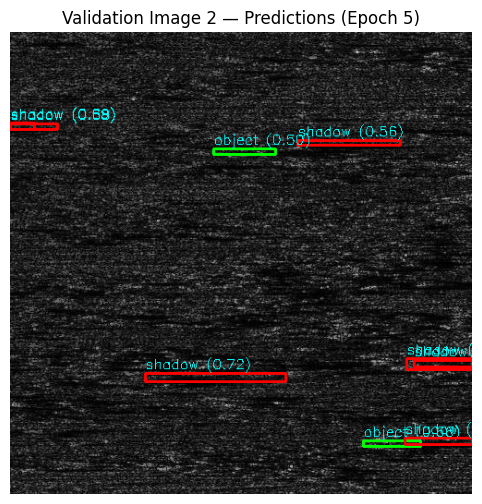

Image 3: 31 predictions above threshold


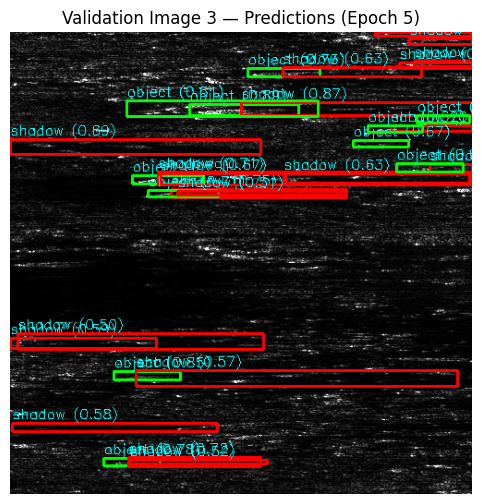

Image 4: 19 predictions above threshold


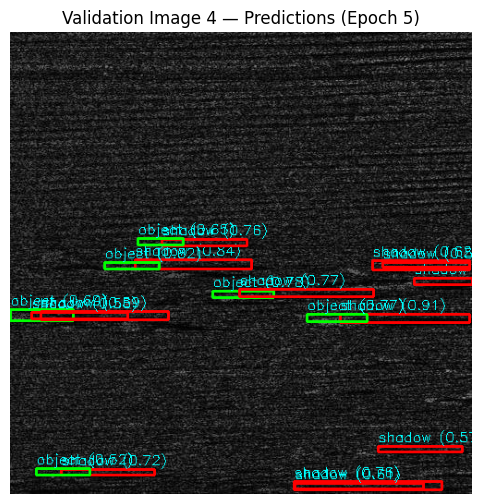

Image 5: 7 predictions above threshold


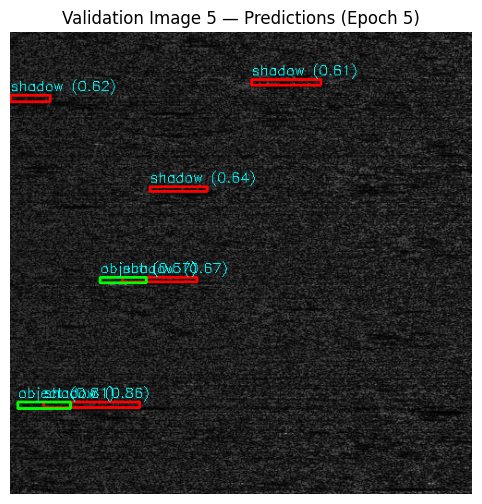

In [5]:
# =============================================================
# VISUALIZE PREDICTIONS FROM FASTER R-CNN (5 EPOCHS)
# =============================================================
# This script loads the trained 5-epoch baseline model (raw data),
# and visualizes predictions for selected images in the validation set.

import os
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Add path to dataset class
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# STEP 1: Load the trained baseline model (raw 5-epoch)
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model architecture
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load the trained weights
checkpoint_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_fasterrcnn_5epoch.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# -------------------------------------------------------------
# STEP 2: Define label names and bounding box colors
# -------------------------------------------------------------
LABEL_NAMES = {1: "object", 2: "shadow"}
LABEL_COLORS = {
    1: (0, 255, 0),   # Green for object
    2: (0, 0, 255)    # Red for shadow
}

# -------------------------------------------------------------
# STEP 3: Define the visualization function
# -------------------------------------------------------------
def visualize(model, dataset_root, num_images=5, image_set="val", confidence_threshold=0.5):
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())

    for i in range(num_images):
        img, _ = dataset[i]
        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)[0]

        # Convert image to OpenCV format
        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()

        count = 0
        # Draw only high-confidence predictions above threshold
        for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
            if score < confidence_threshold:
                continue

            x1, y1, x2, y2 = box.int().tolist()
            class_id = label.item()
            class_name = LABEL_NAMES.get(class_id, "unknown")
            color = LABEL_COLORS.get(class_id, (255, 255, 255))

            cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_np, f"{class_name} ({score:.2f})", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

            count += 1

        print(f"Image {i+1}: {count} predictions above threshold")

        # Display with matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Validation Image {i+1} — Predictions (Epoch 5)")
        plt.show()

        # Save to disk
        if SAVE_OUTPUT:
            save_path = os.path.join(SAVE_DIR, f"{image_set}_sample_{i}.jpg")
            cv2.imwrite(save_path, img_np)

# -------------------------------------------------------------
# STEP 4: Setup output directory
# -------------------------------------------------------------
SAVE_DIR = "/content/drive/MyDrive/sonar-object-detection/outputs/baseline_5epoch_vis"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_OUTPUT = True

# -------------------------------------------------------------
# STEP 5: Run visualization on validation set
# -------------------------------------------------------------
visualize(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc",
    num_images=5,
    image_set="val",
    confidence_threshold=0.5
)

# **Install TorchMetrics**

In [6]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 14.2 MB/s eta 0:00:00


## **evaluate_model.py**

In [7]:
# =============================================================
# EVALUATE FASTER R-CNN BASELINE MODEL USING MEAN AVERAGE PRECISION (mAP)
# =============================================================
# This script evaluates my trained Faster R-CNN model on sonar validation data
# using torchmetrics. I compute mAP@0.5, mean recall, precision, and other
# standard detection metrics. This helps me measure how well the baseline performs
# before applying domain adaptation (DANN).

import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate(model, dataset_root, batch_size=4, image_set="val"):
    """
    Evaluate a trained Faster R-CNN model on a specified data split using torchmetrics.

    Returns mAP@0.5, mAR, and per-class metrics to benchmark the baseline model.

    Args:
        model (torch.nn.Module): Trained Faster R-CNN model.
        dataset_root (str): Root path to Pascal VOC-style dataset.
        batch_size (int): Batch size for inference.
        image_set (str): One of "train", "val", or "test".
    """

    # -------------------------------------------------------------
    # STEP 1: Load the dataset and move model to correct device
    # -------------------------------------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Switch to evaluation mode (no dropout/batchnorm updates)

    # Load Pascal VOC-style dataset using your custom VOCDataset class
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))  # Allows batching of variable-length targets
    )

    # -------------------------------------------------------------
    # STEP 2: Initialize torchmetrics wrapper for mAP and recall
    # -------------------------------------------------------------
    # Uses COCO-style metric computation under the hood
    metric = MeanAveragePrecision()

    # -------------------------------------------------------------
    # STEP 3: Run the model on each batch and collect metrics
    # -------------------------------------------------------------
    with torch.no_grad():  # Disable gradient computation for evaluation
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)  # Run inference

            # Reformat model outputs and ground truths to torchmetrics format
            preds = []
            gts = []
            for o, t in zip(outputs, targets):
                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                gts.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            metric.update(preds, gts)

    # -------------------------------------------------------------
    # STEP 4: Compute and print the final scores
    # -------------------------------------------------------------
    print(f"\nEvaluation Results on '{image_set}' split:")
    print(f"Total samples evaluated: {len(dataset)}")
    print("-" * 45)

    results = metric.compute()  # Final aggregated metrics

    for k, v in results.items():
        try:
            print(f"{k}: {v.item():.4f}")  # Print if scalar value
        except:
            print(f"{k}: {v}")  # Fallback for tensors/lists (e.g. per-class metrics)

# -------------------------------------------------------------
# RUN THE EVALUATION NOW (for validation set)
# -------------------------------------------------------------

evaluate(
    model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc",
    batch_size=4,
    image_set="val"
)


Evaluation Results on 'val' split:
Total samples evaluated: 242
---------------------------------------------
map: 0.0429
map_50: 0.1687
map_75: 0.0075
map_small: 0.0287
map_medium: 0.0643
map_large: 0.0340
mar_1: 0.0219
mar_10: 0.0991
mar_100: 0.1603
mar_small: 0.1202
mar_medium: 0.2225
mar_large: 0.1200
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: tensor([1, 2], dtype=torch.int32)


## **Data Preprocessing Using Median Blur**

In [8]:
# =============================================================
# PREPROCESSING SCRIPT: APPLY MEDIAN BLUR TO DENOISE IMAGES
# =============================================================
# This script takes the raw sonar dataset (in Pascal VOC format) and applies
# a 3x3 median blur to each image to reduce speckle noise. It keeps all original
# annotation files and split lists intact, creating a new dataset version
# under: data/line2voc_preprocessed

import os
import cv2
import shutil
import xml.etree.ElementTree as ET
from pathlib import Path

# -------------------------------------------------------------
# STEP 1: Define folder paths for source and destination
# -------------------------------------------------------------
# We define input (raw dataset) and output (denoised version) folders
# including image, annotation, and split directories

PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")

# Source: raw sonar dataset (already in VOC format)
SRC_IMG_DIR    = PROJECT_ROOT / "data" / "line2voc" / "JPEGImages"
SRC_ANN_DIR    = PROJECT_ROOT / "data" / "line2voc" / "Annotations"
SRC_SPLIT_DIR  = PROJECT_ROOT / "data" / "line2voc" / "ImageSets" / "Main"

# Destination: denoised version (will reuse annotations and splits)
DEST_ROOT      = PROJECT_ROOT / "data" / "line2voc_preprocessed"
DEST_IMG_DIR   = DEST_ROOT / "JPEGImages"
DEST_ANN_DIR   = DEST_ROOT / "Annotations"
DEST_SPLIT_DIR = DEST_ROOT / "ImageSets" / "Main"

# -------------------------------------------------------------
# STEP 2: Create output folders
# -------------------------------------------------------------
# Ensure output folders exist, and clear previous contents
# to prevent mixing with old runs

for folder in [DEST_IMG_DIR, DEST_ANN_DIR, DEST_SPLIT_DIR]:
    folder.mkdir(parents=True, exist_ok=True)
    for file in folder.glob("*"):
        file.unlink()

print("Output directories reset. Starting denoising process...")

# -------------------------------------------------------------
# STEP 3: Apply median filter to each image
# -------------------------------------------------------------
# Median blur helps reduce speckle noise commonly found in sonar images
# while preserving edges better than Gaussian blur.

denoised_count = 0
for img_path in SRC_IMG_DIR.glob("*.jpg"):
    img = cv2.imread(str(img_path))

    # Skip unreadable or broken images
    if img is None:
        print(f"[WARNING] Skipped unreadable image: {img_path}")
        continue

    # Apply median blur with kernel size 3 (edge-preserving smoothing)
    denoised = cv2.medianBlur(img, ksize=3)

    # Save denoised image to destination folder
    out_path = DEST_IMG_DIR / img_path.name
    cv2.imwrite(str(out_path), denoised)
    denoised_count += 1

print(f"{denoised_count} images denoised and saved to: {DEST_IMG_DIR}")

# -------------------------------------------------------------
# STEP 4: Copy Pascal VOC annotation files
# -------------------------------------------------------------
# Annotations do not change since object locations remain fixed.
# Only pixel values are smoothed.

for xml_file in SRC_ANN_DIR.glob("*.xml"):
    shutil.copy(xml_file, DEST_ANN_DIR)

print(f"Annotations copied to: {DEST_ANN_DIR}")

# -------------------------------------------------------------
# STEP 5: Copy train/val/test split text files
# -------------------------------------------------------------
# Preserve the same dataset split (train/val/test) to maintain consistency
# during training and evaluation

for split_file in SRC_SPLIT_DIR.glob("*.txt"):
    shutil.copy(split_file, DEST_SPLIT_DIR)

print(f"Split files copied to: {DEST_SPLIT_DIR}")

# -------------------------------------------------------------
# DONE: Print confirmation
# -------------------------------------------------------------
print(f"\nPreprocessing complete. Denoised dataset available at:\n{DEST_ROOT}")

Output directories reset. Starting denoising process...
1788 images denoised and saved to: /content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed/JPEGImages
Annotations copied to: /content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed/Annotations
Split files copied to: /content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed/ImageSets/Main

Preprocessing complete. Denoised dataset available at:
/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed


## **Load Faster R-CNN and Start Training with Preprocessed Data**

## **train_denoised_fasterrcnn.py**

In [9]:
# =============================================================
# TRAINING FASTER R-CNN ON DENOISED SONAR IMAGES (5 EPOCHS)
# =============================================================
# This script trains Faster R-CNN on denoised sonar images (median blur applied).
# It follows the same setup as my baseline raw model for a fair comparison.
# Only change: images are denoised, and optimizer is AdamW instead of SGD.

# -------------------------------------------------------------
# STEP 0: Import necessary libraries
# -------------------------------------------------------------
import os
import sys
import torch
import torchvision
import torchvision.transforms as T
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Add path to my custom dataset class (voc_dataset.py)
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# STEP 1: Set device
# -------------------------------------------------------------
# Automatically use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------------------------------------
# STEP 2: Collate function for variable-size targets
# -------------------------------------------------------------
# Needed because each image may contain a different number of objects
def collate_fn(batch):
    return tuple(zip(*batch))  # Groups images and targets correctly for detection

# -------------------------------------------------------------
# STEP 3: Load denoised dataset (train + val)
# -------------------------------------------------------------
# Denoised version was created using 3x3 median blur on original sonar data
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed"
transform = T.ToTensor()

train_dataset = VOCDataset(root=DATASET_DIR, image_set="train", transforms=transform)
val_dataset   = VOCDataset(root=DATASET_DIR, image_set="val", transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# -------------------------------------------------------------
# STEP 4: Load pretrained Faster R-CNN with COCO weights
# -------------------------------------------------------------
# Start from torchvision Faster R-CNN backbone pretrained on COCO
# Replace the classifier head to detect 2 classes: object and shadow (plus background)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 3  # 0 = background (implicit), 1 = object, 2 = shadow
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

# -------------------------------------------------------------
# STEP 5: Optimizer — AdamW (Better for sonar than SGD)
# -------------------------------------------------------------
# AdamW = Adam with decoupled weight decay; improves generalization and convergence
# Used instead of SGD due to smaller dataset and fewer epochs
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)

# -------------------------------------------------------------
# STEP 6: Training Loop — 5 Epochs
# -------------------------------------------------------------
# For each epoch:
#   - Run model in training mode
#   - Compute detection losses (classification, box regression, RPN)
#   - Backpropagate and update weights using AdamW

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())  # Total loss = sum of all detection components
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")

# -------------------------------------------------------------
# STEP 7: Save model checkpoint to checkpoints/
# -------------------------------------------------------------
# Save only model weights (not optimizer or full model) for later reuse
os.makedirs("/content/drive/MyDrive/sonar-object-detection/checkpoints", exist_ok=True)

save_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/denoised_fasterrcnn_5epoch.pth"
torch.save(model.state_dict(), save_path)
print(f"\nModel saved to: {save_path}")

Using device: cuda
Training samples: 1366
Validation samples: 242


Epoch 1/5: 100%|██████████| 342/342 [00:42<00:00,  8.00it/s]


Epoch 1/5 — Avg Loss: 1.1816


Epoch 2/5: 100%|██████████| 342/342 [00:42<00:00,  8.01it/s]


Epoch 2/5 — Avg Loss: 1.0885


Epoch 3/5: 100%|██████████| 342/342 [00:42<00:00,  8.01it/s]


Epoch 3/5 — Avg Loss: 1.0526


Epoch 4/5: 100%|██████████| 342/342 [00:42<00:00,  8.00it/s]


Epoch 4/5 — Avg Loss: 1.0318


Epoch 5/5: 100%|██████████| 342/342 [00:42<00:00,  8.02it/s]


Epoch 5/5 — Avg Loss: 1.0066

Model saved to: /content/drive/MyDrive/sonar-object-detection/checkpoints/denoised_fasterrcnn_5epoch.pth


## **Inference**

In [10]:
# =============================================================
# BATCH INFERENCE: APPLY DENOISED FASTER R-CNN TO ALL IMAGES
# =============================================================
# Runs inference on all denoised sonar images. Outputs:
# 1. Visual annotated images (with bounding boxes)
# 2. CSV file with all predictions.

import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------------------------------------
# STEP 1: CONFIGURATION
# -------------------------------------------------------------
# Set paths for images, model weights, output folders, and prediction CSV

PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR      = PROJECT_ROOT / "data" / "line2voc_preprocessed" / "JPEGImages"
MODEL_PATH   = PROJECT_ROOT / "checkpoints" / "denoised_fasterrcnn_5epoch.pth"
OUTPUT_DIR   = PROJECT_ROOT / "outputs" / "vis_denoised_5epoch"
PRED_CSV     = PROJECT_ROOT / "outputs" / "preds_denoised_5epoch.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------
# STEP 2: INFERENCE DATASET
# -------------------------------------------------------------
# Dataset returns both:
# - Tensor for model input
# - NumPy image for OpenCV visualization

class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = list(Path(image_dir).glob("*.jpg"))
        self.transform = transform or ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_pil = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(img_pil)              # For model
        img_np = np.array(img_pil).astype(np.uint8)       # For visualization
        return img_tensor, img_path.name, img_np

# -------------------------------------------------------------
# STEP 3: LOAD MODEL
# -------------------------------------------------------------
# Load Faster R-CNN model trained on denoised data.
# Replace classifier head and load weights.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()  # Set to inference mode

# -------------------------------------------------------------
# STEP 4: INFERENCE
# -------------------------------------------------------------
# For each image batch:
# - Run detection
# - Filter by confidence threshold
# - Draw boxes and labels
# - Store predictions in a CSV-compatible format

CLASS_NAMES = {1: "object", 2: "shadow"}
CLASS_COLORS = {
    1: (0, 255, 0),   # Green for object
    2: (0, 0, 255)    # Red for shadow
}

dataset = InferenceDataset(IMG_DIR)
loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=lambda x: list(zip(*x)))
all_preds = []

print("Running batch inference...")

for batch_imgs, batch_filenames, batch_np_imgs in tqdm(loader, desc="Running Inference"):
    imgs_tensor = [img.to(device) for img in batch_imgs]

    with torch.no_grad():  # Disable gradient tracking for speed/memory
        outputs = model(imgs_tensor)

    for output, fname, img_np in zip(outputs, batch_filenames, batch_np_imgs):
        img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        boxes  = output["boxes"].cpu()
        scores = output["scores"].cpu()
        labels = output["labels"].cpu()

        for box, score, label in zip(boxes, scores, labels):
            score = score.item()
            if score < 0.5:
                continue  # Filter out low-confidence detections

            x1, y1, x2, y2 = map(int, box.tolist())
            class_id = label.item()
            class_name = CLASS_NAMES.get(class_id, "unknown")
            color = CLASS_COLORS.get(class_id, (255, 255, 255))

            all_preds.append({
                "filename": fname,
                "class_id": class_id,
                "class_name": class_name,
                "score": round(score, 4),
                "xmin": x1,
                "ymin": y1,
                "xmax": x2,
                "ymax": y2,
            })

            # Draw box and label on image
            cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv2, f"{class_name} ({score:.2f})", (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        # Save annotated image
        out_path = OUTPUT_DIR / fname
        cv2.imwrite(str(out_path), img_cv2)

# -------------------------------------------------------------
# STEP 5: SAVE PREDICTIONS
# -------------------------------------------------------------
# Write all prediction metadata (class, score, box coordinates) to CSV

df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print("Batch inference complete.")
print(f"Total images processed: {len(dataset)}")
print(f"Visuals saved to      : {OUTPUT_DIR}")
print(f"Predictions saved to  : {PRED_CSV}")

Running batch inference...


Running Inference: 100%|██████████| 447/447 [09:15<00:00,  1.24s/it]


Batch inference complete.
Total images processed: 1788
Visuals saved to      : /content/drive/MyDrive/sonar-object-detection/outputs/vis_denoised_5epoch
Predictions saved to  : /content/drive/MyDrive/sonar-object-detection/outputs/preds_denoised_5epoch.csv


## **evaluate_denoised_model.py**

In [11]:
# =============================================================
# EVALUATE DENOISED FASTER R-CNN MODEL USING MEAN AVERAGE PRECISION (mAP)
# =============================================================
# This script loads the Faster R-CNN model trained on the denoised sonar dataset,
# evaluates it on the validation split, and prints out object detection metrics
# using torchmetrics — including mAP@0.5, mAR@100, precision, recall, etc.

# -------------------------------------------------------------
# STEP 0: Import required modules and dataset class
# -------------------------------------------------------------

import sys
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------------------------------------
# STEP 1: Load model with correct architecture and checkpoint
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize base Faster R-CNN model (pretrained on COCO)
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace COCO head with sonar-specific one: 3 classes (background, object, shadow)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load weights trained on denoised sonar images
checkpoint_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/denoised_fasterrcnn_5epoch.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# -------------------------------------------------------------
# STEP 2: Define evaluation function (torchmetrics)
# -------------------------------------------------------------
def evaluate(model, dataset_root, batch_size=4, image_set="val"):
    """
    Evaluate the Faster R-CNN model using mAP, recall, precision.

    Args:
        model (torch.nn.Module): Trained object detector.
        dataset_root (str): Path to Pascal VOC-format dataset (denoised version).
        batch_size (int): Batch size for inference.
        image_set (str): Dataset split to evaluate ("val" by default).
    """
    model.to(device)
    model.eval()  # Disable dropout and batchnorm updates

    # Load dataset split (e.g., "val") from denoised Pascal VOC folder
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))  # Ensures batching works with variable-length annotations
    )

    # Initialize torchmetrics object for COCO-style detection metrics
    metric = MeanAveragePrecision()

    # Inference loop with no gradient tracking
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)

            # Format predictions and ground truths to torchmetrics format
            preds = []
            gts = []
            for o, t in zip(outputs, targets):
                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                gts.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            metric.update(preds, gts)

    # Compute and display results (mAP@0.5, mAR@100, per-class stats)
    print(f"\nEvaluation Results on Denoised '{image_set}' Split:")
    results = metric.compute()
    for k, v in results.items():
        try:
            print(f"{k}: {v.item():.4f}")  # Scalar metric (e.g., mAP)
        except:
            print(f"{k}: {v}")  # Handles tensor/list outputs (e.g., per-class mAR)

# -------------------------------------------------------------
# STEP 3: Run evaluation on the denoised validation set
# -------------------------------------------------------------
evaluate(
    model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed",
    batch_size=4,
    image_set="val"
)


Evaluation Results on Denoised 'val' Split:
map: 0.0435
map_50: 0.1718
map_75: 0.0060
map_small: 0.0322
map_medium: 0.0610
map_large: 0.0173
mar_1: 0.0208
mar_10: 0.0982
mar_100: 0.1586
mar_small: 0.1186
mar_medium: 0.2233
mar_large: 0.0300
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: tensor([1, 2], dtype=torch.int32)


## **visualize_predictions_denoised.py**

Image 1: 26 predictions above threshold


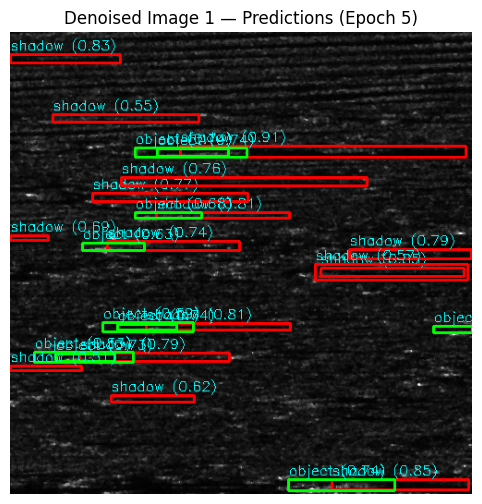

Image 2: 13 predictions above threshold


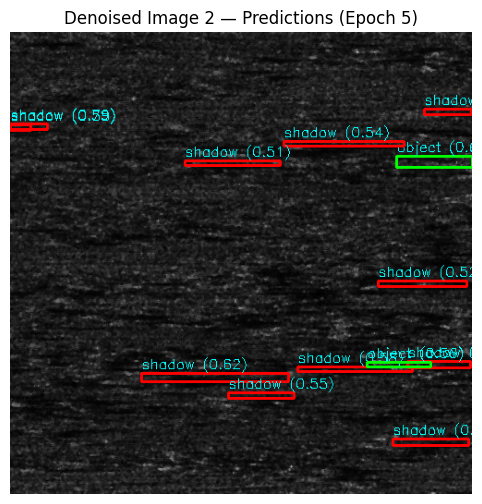

Image 3: 44 predictions above threshold


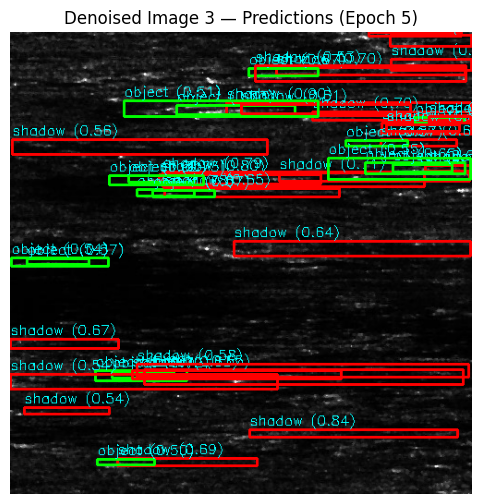

Image 4: 18 predictions above threshold


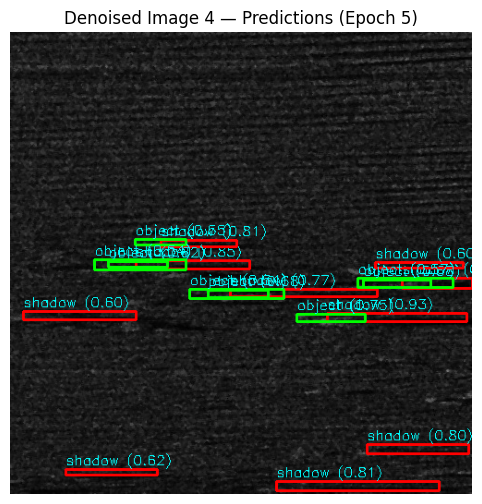

Image 5: 6 predictions above threshold


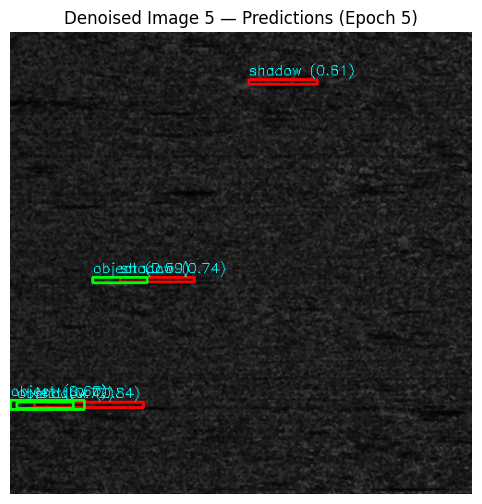

In [12]:
# =============================================================
# VISUALIZE PREDICTIONS FROM FASTER R-CNN (5 EPOCHS) - DENOISED DATA
# =============================================================
# This script loads the Faster R-CNN model trained on denoised sonar images
# and visualizes prediction results on selected validation samples.
# Used for qualitative assessment of bounding box accuracy.

import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Add path to dataset loader
import sys
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# STEP 0: Load trained model with COCO weights (as during training)
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start with a COCO-pretrained backbone (same as training setup)
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace COCO head with a 3-class output (background, object, shadow)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load the weights trained on the denoised sonar dataset (5 epochs)
checkpoint_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/denoised_fasterrcnn_5epoch.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

model.to(device)
model.eval()  # Set to evaluation mode (no gradients)

# -------------------------------------------------------------
# STEP 1: Label names and class colors
# -------------------------------------------------------------
LABEL_NAMES = {1: "object", 2: "shadow"}
LABEL_COLORS = {1: (0, 255, 0), 2: (0, 0, 255)}  # green = object, red = shadow

# -------------------------------------------------------------
# STEP 2: Define visualization function
# -------------------------------------------------------------
def visualize(model, dataset_root, num_images=5, image_set="val", confidence_threshold=0.5):
    """
    Display visual predictions from Faster R-CNN model on sample sonar images.

    Args:
        model (torch.nn.Module): Trained model to use for inference.
        dataset_root (str): Path to dataset (VOC format).
        num_images (int): Number of samples to visualize.
        image_set (str): Dataset split ("val" by default).
        confidence_threshold (float): Score threshold for showing predictions.
    """
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())

    for i in range(num_images):
        img, _ = dataset[i]
        img_tensor = img.unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():  # Inference only
            output = model(img_tensor)[0]

        # Convert image from tensor [C, H, W] → OpenCV [H, W, C]
        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()

        count = 0
        for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
            if score < confidence_threshold:
                continue  # Skip low-confidence detections

            x1, y1, x2, y2 = box.int().tolist()
            class_id = label.item()
            class_name = LABEL_NAMES.get(class_id, "unknown")
            color = LABEL_COLORS.get(class_id, (255, 255, 255))  # Default: white

            # Draw bounding box and label on image
            cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_np, f"{class_name} ({score:.2f})", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

            count += 1

        print(f"Image {i+1}: {count} predictions above threshold")

        # Display using matplotlib (not OpenCV, to avoid color issues)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Denoised Image {i+1} — Predictions (Epoch 5)")
        plt.show()

        # Save to disk (optional)
        if SAVE_OUTPUT:
            save_path = os.path.join(SAVE_DIR, f"val_sample_{i}.jpg")
            cv2.imwrite(save_path, img_np)

# -------------------------------------------------------------
# STEP 3: Output path and run visualization
# -------------------------------------------------------------
SAVE_DIR = "/content/drive/MyDrive/sonar-object-detection/outputs/vis_denoised_5epoch"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_OUTPUT = True

visualize(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed",
    num_images=5,
    image_set="val",
    confidence_threshold=0.5
)

In [13]:
# =============================================================
# COUNT ANNOTATIONS IN DENOISED SONAR DATASET (VOC FORMAT)
# =============================================================
# This script parses all XML annotation files in the denoised dataset
# and counts how many "object" and "shadow" labels are present.
# Useful for understanding class imbalance before training.

import os
from pathlib import Path
from xml.etree import ElementTree as ET

# Initialize counters for object and shadow instances
shadow_count = 0
object_count = 0

# Path to Pascal VOC annotation files in denoised dataset
path = Path("/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed/Annotations")

# Iterate over each annotation file and extract class labels
for xml_file in path.glob("*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for obj in root.findall("object"):
        name = obj.find("name").text.strip().lower()
        if name == "shadow":
            shadow_count += 1
        elif name == "object":
            object_count += 1

# Print final counts
print(f"Object count: {object_count}")
print(f"Shadow count: {shadow_count}")

Object count: 12842
Shadow count: 15079


## **preprocess_with_clahe_and_aug.py**




In [14]:
# =============================================================
# PREPROCESSING SCRIPT: CLAHE + AUGMENTATION + SHADOW LABELS
# =============================================================
# This script applies denoising, CLAHE enhancement, and augmentations
# to sonar images. It updates bounding boxes when flipping is applied,
# and reuses original VOC annotations and split files.

import os
import cv2
import shutil
import random
import numpy as np
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm  # Progress bar

# -------------------------------------------------------------
# STEP 1: Setup directory paths and clear old outputs
# -------------------------------------------------------------
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")

# Source: base raw dataset (VOC format)
SRC_IMG_DIR = PROJECT_ROOT / "data" / "line2voc" / "JPEGImages"
SRC_ANN_DIR = PROJECT_ROOT / "data" / "line2voc" / "Annotations"
SRC_SPLIT_DIR = PROJECT_ROOT / "data" / "line2voc" / "ImageSets" / "Main"

# Destination: enhanced dataset with CLAHE + augmentation
DEST_ROOT = PROJECT_ROOT / "data" / "line2voc_preprocessed_augmented"
DEST_IMG_DIR = DEST_ROOT / "JPEGImages"
DEST_ANN_DIR = DEST_ROOT / "Annotations"
DEST_SPLIT_DIR = DEST_ROOT / "ImageSets" / "Main"

# Prepare destination folders and clean old outputs
for folder in [DEST_IMG_DIR, DEST_ANN_DIR, DEST_SPLIT_DIR]:
    folder.mkdir(parents=True, exist_ok=True)
    for file in folder.glob("*"):
        file.unlink()

print("Old outputs from augmented CLAHE dataset cleared.")

# -------------------------------------------------------------
# STEP 2: Helper functions for CLAHE and augmentations
# -------------------------------------------------------------

def apply_clahe(img):
    """Apply CLAHE to the lightness channel of a LAB image to improve local contrast."""
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced = cv2.merge((cl, a, b))
    return cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)

def apply_augmentations(img):
    """Apply flip, rotation, and contrast/brightness jitter to simulate sonar variations."""
    if random.random() < 0.5:
        img = cv2.flip(img, 1)

    angle = random.uniform(-10, 10)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT101)

    brightness = random.uniform(0.9, 1.1)
    contrast = random.uniform(0.9, 1.1)
    img = np.clip(contrast * img + brightness * 10, 0, 255).astype(np.uint8)

    return img

def update_bboxes_after_flip(xml_path, img_width):
    """Update bounding box coordinates after a horizontal flip is applied."""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        xmax = int(bbox.find('xmax').text)

        # Invert horizontal position of boxes
        bbox.find('xmin').text = str(img_width - xmax)
        bbox.find('xmax').text = str(img_width - xmin)

    tree.write(xml_path)

# -------------------------------------------------------------
# STEP 3: Process images (denoise → CLAHE → augment)
# -------------------------------------------------------------
count = 0
for img_path in tqdm(SRC_IMG_DIR.glob("*.jpg"), desc="Processing Images"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Skipped unreadable image: {img_path}")
        continue

    # Step 1: Apply 3x3 median blur to reduce speckle noise
    img = cv2.medianBlur(img, 3)

    # Step 2: Apply CLAHE to boost local contrast in low-contrast sonar images
    img = apply_clahe(img)

    # Step 3: Randomly apply horizontal flip
    flipped = False
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
        flipped = True

    # Step 4: Random rotation and photometric distortion
    angle = random.uniform(-10, 10)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT101)

    brightness = random.uniform(0.9, 1.1)
    contrast = random.uniform(0.9, 1.1)
    img = np.clip(contrast * img + brightness * 10, 0, 255).astype(np.uint8)

    # Save the final augmented image
    out_path = DEST_IMG_DIR / img_path.name
    cv2.imwrite(str(out_path), img)

    # ---------------------------------------------------------
    # Process the annotation
    # ---------------------------------------------------------
    xml_path = SRC_ANN_DIR / f"{img_path.stem}.xml"
    if not xml_path.exists():
        print(f"Missing annotation for {img_path.name}, skipping.")
        continue

    # Parse annotation XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # If flipped, update bounding box coordinates accordingly
    if flipped:
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            xmax = int(bbox.find("xmax").text)
            bbox.find("xmin").text = str(w - xmax)
            bbox.find("xmax").text = str(w - xmin)

    # Save updated annotation
    out_ann_path = DEST_ANN_DIR / f"{img_path.stem}.xml"
    tree.write(out_ann_path)

    count += 1

print(f"{count} images processed and saved to: {DEST_IMG_DIR}")

# -------------------------------------------------------------
# STEP 4: Copy image set split files (train.txt, val.txt, etc.)
# -------------------------------------------------------------
# Preserve the same train/val/test splits from original dataset

for split_file in SRC_SPLIT_DIR.glob("*.txt"):
    shutil.copy(split_file, DEST_SPLIT_DIR)

print("Image set splits copied.")
print(f"Augmented CLAHE dataset is ready at: {DEST_ROOT}")

Old outputs from augmented CLAHE dataset cleared.


Processing Images: 1788it [01:01, 29.29it/s]

1788 images processed and saved to: /content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented/JPEGImages
Image set splits copied.
Augmented CLAHE dataset is ready at: /content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented


## **train_augmented_fasterrcnn.py**

In [15]:
# =============================================================
# TRAINING FASTER R-CNN ON CLAHE + AUGMENTED SONAR IMAGES (5 EPOCHS)
# =============================================================
# This script trains Faster R-CNN on the CLAHE-enhanced and augmented
# sonar dataset. It follows the same structure as the other baselines
# to allow direct comparison of preprocessing strategies.

import os
import sys
import torch
import torchvision
import torchvision.transforms as T
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------------------------------------
# STEP 0: Setup custom dataset class and paths
# -------------------------------------------------------------
# Load dataset wrapper and define augmented dataset path
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------------------------------------
# STEP 1: Define collate function and data loaders
# -------------------------------------------------------------
# Custom collate function to handle variable-length target lists
def collate_fn(batch):
    return tuple(zip(*batch))

transform = T.ToTensor()

# Load VOC-style dataset splits
train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset   = VOCDataset(DATASET_DIR, image_set="val", transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# -------------------------------------------------------------
# STEP 2: Load Faster R-CNN model (COCO pretrained) and replace head
# -------------------------------------------------------------
# Use torchvision's COCO-pretrained model and modify it for 3 sonar classes
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)  # 0=background, 1=object, 2=shadow

model.to(device)

# -------------------------------------------------------------
# STEP 3: Set optimizer (AdamW for better generalization)
# -------------------------------------------------------------
# AdamW helps reduce overfitting and handles noisy sonar data better than vanilla SGD
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)

# -------------------------------------------------------------
# STEP 4: Training loop for 5 epochs
# -------------------------------------------------------------
# Standard training loop: forward pass → compute loss → backprop → update weights

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")

# -------------------------------------------------------------
# STEP 5: Save trained model to checkpoints
# -------------------------------------------------------------
# Save final model weights (for reproducibility and evaluation)
os.makedirs("/content/drive/MyDrive/sonar-object-detection/checkpoints", exist_ok=True)
save_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/augmented_fasterrcnn.pth"
torch.save(model.state_dict(), save_path)

print(f"\nModel saved to: {save_path}")

Using device: cuda
Training samples: 1366
Validation samples: 242


Epoch 1/5: 100%|██████████| 342/342 [00:43<00:00,  7.94it/s]


Epoch 1/5 — Avg Loss: 1.1476


Epoch 2/5: 100%|██████████| 342/342 [00:42<00:00,  7.98it/s]


Epoch 2/5 — Avg Loss: 1.0856


Epoch 3/5: 100%|██████████| 342/342 [00:42<00:00,  7.99it/s]


Epoch 3/5 — Avg Loss: 1.0661


Epoch 4/5: 100%|██████████| 342/342 [00:42<00:00,  7.98it/s]


Epoch 4/5 — Avg Loss: 1.0592


Epoch 5/5: 100%|██████████| 342/342 [00:42<00:00,  7.98it/s]


Epoch 5/5 — Avg Loss: 1.0483

Model saved to: /content/drive/MyDrive/sonar-object-detection/checkpoints/augmented_fasterrcnn.pth


## **inference_and_visualization_augmented.py**

In [16]:
# =============================================================
# BATCH INFERENCE ON CLAHE & AUGMENTED SONAR IMAGES
# =============================================================
# Applies Faster R-CNN to every image in the CLAHE-augmented dataset.
# Saves annotated visuals and a CSV with detection results.

import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------------------------------------
# STEP 1: CONFIGURATION
# -------------------------------------------------------------
# Define input image path, trained model checkpoint, and output folders

PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR      = PROJECT_ROOT / "data" / "line2voc_preprocessed_augmented" / "JPEGImages"
MODEL_PATH   = PROJECT_ROOT / "checkpoints" / "augmented_fasterrcnn.pth"
OUTPUT_DIR   = PROJECT_ROOT / "outputs" / "vis_augmented"
PRED_CSV     = PROJECT_ROOT / "outputs" / "preds_augmented.csv"

# Create output folders if they don’t exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------
# STEP 2: INFERENCE DATASET
# -------------------------------------------------------------
# Custom dataset that returns both image tensor (for model)
# and NumPy image (for OpenCV visualization)

class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = list(Path(image_dir).glob("*.jpg"))
        self.transform = transform or ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_pil = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(img_pil)
        img_np = np.array(img_pil).astype(np.uint8)
        return img_tensor, img_path.name, img_np

# -------------------------------------------------------------
# STEP 3: LOAD MODEL
# -------------------------------------------------------------
# Load model architecture, replace classifier head, and load trained weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load weights trained on CLAHE + augmented data
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()  # Set to eval mode to disable dropout/batchnorm

# -------------------------------------------------------------
# STEP 4: INFERENCE
# -------------------------------------------------------------
# Run model on every image, draw bounding boxes, and save detections to CSV

CLASS_NAMES = {1: "object", 2: "shadow"}
CLASS_COLORS = {
    1: (0, 255, 0),   # Green for object
    2: (0, 0, 255)    # Red for shadow
}

dataset = InferenceDataset(IMG_DIR)
loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=lambda x: list(zip(*x)))
all_preds = []

print("Running batch inference on CLAHE + Augmented images...")

for batch_imgs, batch_filenames, batch_np_imgs in tqdm(loader, desc="Running Inference"):
    imgs_tensor = [img.to(device) for img in batch_imgs]

    with torch.no_grad():
        outputs = model(imgs_tensor)

    for output, fname, img_np in zip(outputs, batch_filenames, batch_np_imgs):
        img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        boxes  = output["boxes"].cpu()
        scores = output["scores"].cpu()
        labels = output["labels"].cpu()

        for box, score, label in zip(boxes, scores, labels):
            score = score.item()
            if score < 0.5:
                continue  # Skip low-confidence detections

            x1, y1, x2, y2 = map(int, box.tolist())
            class_id = label.item()
            class_name = CLASS_NAMES.get(class_id, "unknown")
            color = CLASS_COLORS.get(class_id, (255, 255, 255))  # White fallback

            all_preds.append({
                "filename": fname,
                "class_id": class_id,
                "class_name": class_name,
                "score": round(score, 4),
                "xmin": x1,
                "ymin": y1,
                "xmax": x2,
                "ymax": y2,
            })

            # Draw bounding box and class label
            cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv2, f"{class_name} ({score:.2f})", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        # Save annotated image
        out_path = OUTPUT_DIR / fname
        cv2.imwrite(str(out_path), img_cv2)

# -------------------------------------------------------------
# STEP 5: SAVE PREDICTIONS
# -------------------------------------------------------------
# Write all predictions (bounding boxes, scores, labels) to CSV

df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print("Batch inference complete.")
print(f"Total images processed: {len(dataset)}")
print(f"Visuals saved to      : {OUTPUT_DIR}")
print(f"Predictions saved to  : {PRED_CSV}")

Running batch inference on CLAHE + Augmented images...


Running Inference: 100%|██████████| 447/447 [09:18<00:00,  1.25s/it]


Batch inference complete.
Total images processed: 1788
Visuals saved to      : /content/drive/MyDrive/sonar-object-detection/outputs/vis_augmented
Predictions saved to  : /content/drive/MyDrive/sonar-object-detection/outputs/preds_augmented.csv


## **evaluate_augmented_model.py**

In [17]:
# =============================================================
# EVALUATE CLAHE + AUGMENTED FASTER R-CNN MODEL (VAL SET)
# =============================================================
# Loads the model trained on CLAHE + augmented sonar images,
# runs evaluation on the validation set, and computes mAP@0.5,
# mean recall, and other detection metrics using torchmetrics.

import sys
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# -------------------------------------------------------------
# STEP 0: Load custom dataset class
# -------------------------------------------------------------
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# STEP 1: Device and Model Setup
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Faster R-CNN backbone pretrained on COCO
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace the classifier head for 3 sonar classes: background, object, shadow
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)

# Load model weights trained on CLAHE + augmented sonar data
model_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/augmented_fasterrcnn.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# -------------------------------------------------------------
# STEP 2: Load validation dataset (VOC format)
# -------------------------------------------------------------
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented"
val_dataset = VOCDataset(DATASET_DIR, image_set="val", transforms=T.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# -------------------------------------------------------------
# STEP 3: Initialize mAP metric using torchmetrics
# -------------------------------------------------------------
metric = MeanAveragePrecision()

# -------------------------------------------------------------
# STEP 4: Evaluate model on validation set
# -------------------------------------------------------------
with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(imgs)

        # Format predictions and targets for torchmetrics
        preds = [{
            "boxes": o["boxes"].cpu(),
            "scores": o["scores"].cpu(),
            "labels": o["labels"].cpu()
        } for o in outputs]

        targs = [{
            "boxes": t["boxes"].cpu(),
            "labels": t["labels"].cpu()
        } for t in targets]

        metric.update(preds, targs)

# -------------------------------------------------------------
# STEP 5: Compute and print evaluation metrics
# -------------------------------------------------------------
print("\nEvaluation Results (CLAHE + Augmented Model):")
results = metric.compute()
for k, v in results.items():
    print(f"{k}: {v.item():.4f}" if isinstance(v, torch.Tensor) and v.numel() == 1 else f"{k}: {v}")


Evaluation Results (CLAHE + Augmented Model):
map: 0.0050
map_50: 0.0180
map_75: 0.0004
map_small: 0.0013
map_medium: 0.0076
map_large: 0.0001
mar_1: 0.0034
mar_10: 0.0152
mar_100: 0.0402
mar_small: 0.0138
mar_medium: 0.0723
mar_large: 0.0500
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: tensor([1, 2], dtype=torch.int32)


## **visualize_predictions_augmented.py**

Image 1: 0 predictions above threshold


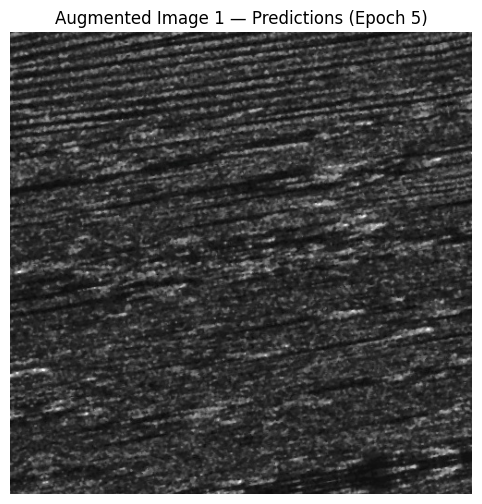

Image 2: 0 predictions above threshold


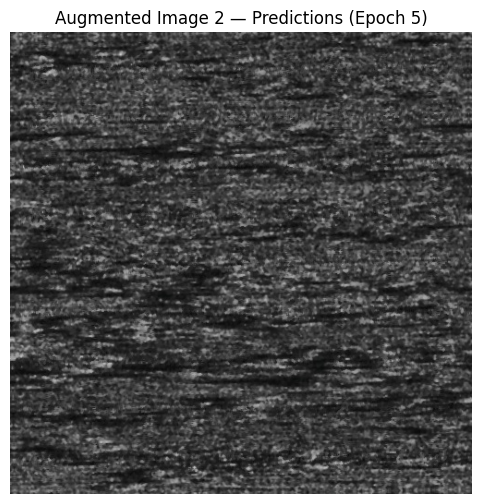

Image 3: 3 predictions above threshold


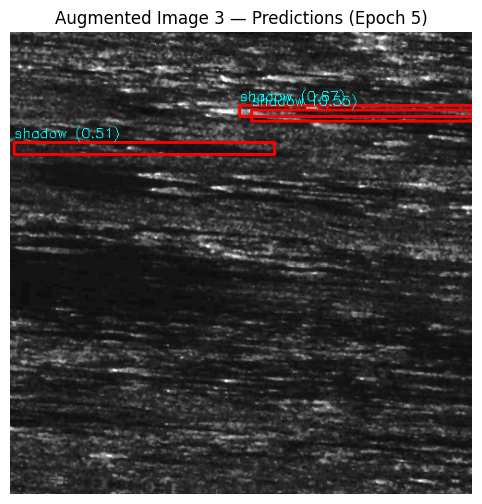

Image 4: 0 predictions above threshold


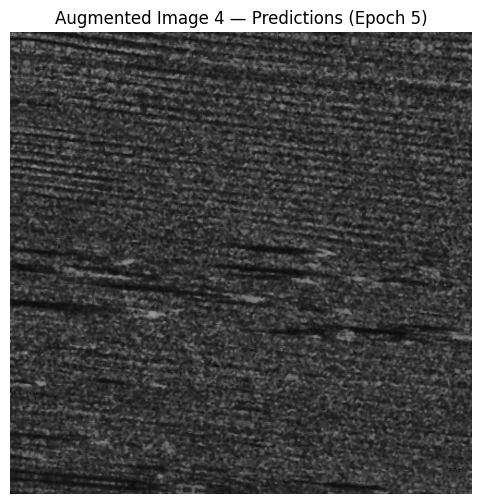

Image 5: 0 predictions above threshold


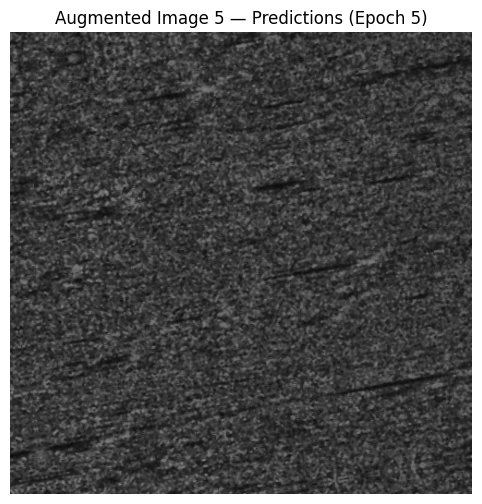

In [18]:
# =============================================================
# VISUALIZE PREDICTIONS (CLAHE + AUGMENTED DATASET)
# =============================================================
# Loads the trained Faster R-CNN model (CLAHE + augmented training),
# applies it to a few validation images, and overlays predictions
# for visual inspection (bounding boxes and labels).

import os
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------------------------------------
# STEP 0: Setup imports and model
# -------------------------------------------------------------
# Load dataset class
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Faster R-CNN architecture and modify the classification head
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)

# Load weights trained on CLAHE + augmented sonar images
model_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/augmented_fasterrcnn.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# -------------------------------------------------------------
# STEP 1: Define label mapping and output settings
# -------------------------------------------------------------
LABEL_NAMES = {1: "object", 2: "shadow"}
LABEL_COLORS = {1: (0, 255, 0), 2: (0, 0, 255)}  # Green for object, red for shadow

SAVE_DIR = "/content/drive/MyDrive/sonar-object-detection/outputs/vis_augmented"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_OUTPUT = True

# -------------------------------------------------------------
# STEP 2: Visualization function for model predictions
# -------------------------------------------------------------
def visualize(model, dataset_root, num_images=5, image_set="val", confidence_threshold=0.5):
    """
    Displays predictions from the trained model on sonar images from the given dataset split.
    Useful for visually verifying bounding box quality and class detection accuracy.
    """
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())

    for i in range(num_images):
        img, _ = dataset[i]
        img_tensor = img.unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            output = model(img_tensor)[0]

        # Convert to OpenCV image for annotation
        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()

        count = 0
        for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
            if score < confidence_threshold:
                continue  # Skip low-confidence predictions

            x1, y1, x2, y2 = box.int().tolist()
            class_id = label.item()
            class_name = LABEL_NAMES.get(class_id, "unknown")
            color = LABEL_COLORS.get(class_id, (255, 255, 255))  # White fallback for unknown class

            # Draw bounding box and label
            cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_np, f"{class_name} ({score:.2f})", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

            count += 1

        print(f"Image {i+1}: {count} predictions above threshold")

        # Show prediction result using matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Augmented Image {i+1} — Predictions (Epoch 5)")
        plt.show()

        # Save annotated output if enabled
        if SAVE_OUTPUT:
            save_path = os.path.join(SAVE_DIR, f"val_sample_{i}.jpg")
            cv2.imwrite(save_path, img_np)

# -------------------------------------------------------------
# STEP 3: Run the visualization
# -------------------------------------------------------------
visualize(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented",
    num_images=5,
    image_set="val",
    confidence_threshold=0.5
)